Epoch 1/50
52/52 [==============================] - 1s 5ms/step - loss: 0.8305 - accuracy: 0.4737 - val_loss: 0.8100 - val_accuracy: 0.4370
Epoch 2/50
52/52 [==============================] - 0s 2ms/step - loss: 0.7961 - accuracy: 0.5148 - val_loss: 0.7810 - val_accuracy: 0.6324
Epoch 3/50
52/52 [==============================] - 0s 2ms/step - loss: 0.7720 - accuracy: 0.5733 - val_loss: 0.7586 - val_accuracy: 0.6889
Epoch 4/50
52/52 [==============================] - 0s 2ms/step - loss: 0.7419 - accuracy: 0.6144 - val_loss: 0.7323 - val_accuracy: 0.6967
Epoch 5/50
52/52 [==============================] - 0s 2ms/step - loss: 0.7198 - accuracy: 0.6317 - val_loss: 0.7029 - val_accuracy: 0.7275
Epoch 6/50
52/52 [==============================] - 0s 2ms/step - loss: 0.6992 - accuracy: 0.6395 - val_loss: 0.6693 - val_accuracy: 0.7558
Epoch 7/50
52/52 [==============================] - 0s 2ms/step - loss: 0.6758 - accuracy: 0.6581 - val_loss: 0.6263 - val_accuracy: 0.7995
Epoch 8/50
52/52 [==

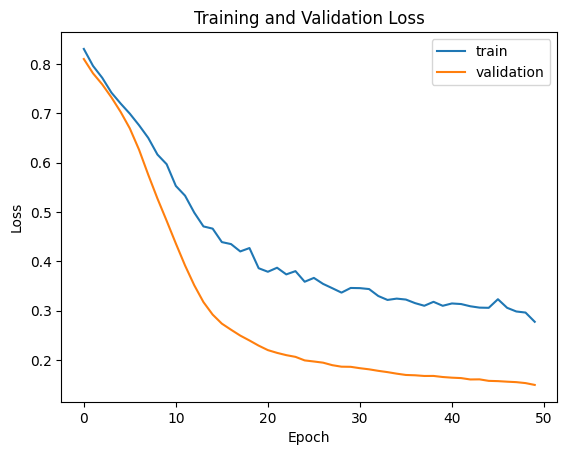

Accuracy for data/AAPL_daily.csv: 99.74%
Epoch 1/50
42/42 [==============================] - 1s 5ms/step - loss: 0.8113 - accuracy: 0.5861 - val_loss: 0.7950 - val_accuracy: 0.6019
Epoch 2/50
42/42 [==============================] - 0s 2ms/step - loss: 0.7822 - accuracy: 0.5917 - val_loss: 0.7727 - val_accuracy: 0.6306
Epoch 3/50
42/42 [==============================] - 0s 2ms/step - loss: 0.7686 - accuracy: 0.5869 - val_loss: 0.7547 - val_accuracy: 0.6561
Epoch 4/50
42/42 [==============================] - 0s 2ms/step - loss: 0.7494 - accuracy: 0.6053 - val_loss: 0.7317 - val_accuracy: 0.7325
Epoch 5/50
42/42 [==============================] - 0s 2ms/step - loss: 0.7312 - accuracy: 0.6220 - val_loss: 0.7086 - val_accuracy: 0.7898
Epoch 6/50
42/42 [==============================] - 0s 2ms/step - loss: 0.7285 - accuracy: 0.6021 - val_loss: 0.6908 - val_accuracy: 0.8185
Epoch 7/50
42/42 [==============================] - 0s 2ms/step - loss: 0.7066 - accuracy: 0.6483 - val_loss: 0.6701 - 

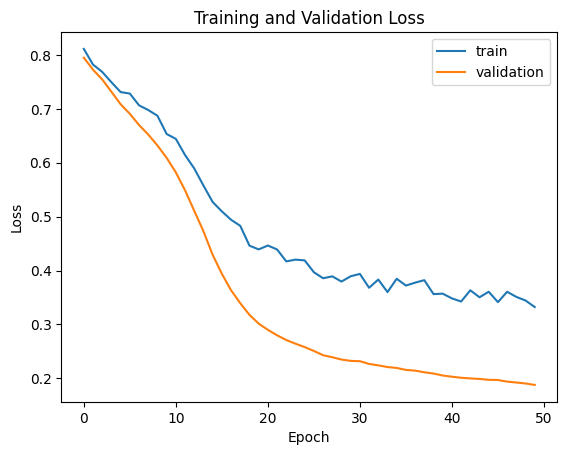

Accuracy for data/nvda_daily.csv: 99.68%
Epoch 1/50
47/47 [==============================] - 1s 5ms/step - loss: 0.9072 - accuracy: 0.5196 - val_loss: 0.7671 - val_accuracy: 0.6866
Epoch 2/50
47/47 [==============================] - 0s 2ms/step - loss: 0.8496 - accuracy: 0.5431 - val_loss: 0.7301 - val_accuracy: 0.7293
Epoch 3/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7930 - accuracy: 0.5588 - val_loss: 0.6987 - val_accuracy: 0.7521
Epoch 4/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7725 - accuracy: 0.5723 - val_loss: 0.6681 - val_accuracy: 0.7892
Epoch 5/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7258 - accuracy: 0.6066 - val_loss: 0.6380 - val_accuracy: 0.8034
Epoch 6/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7103 - accuracy: 0.6258 - val_loss: 0.6079 - val_accuracy: 0.8490
Epoch 7/50
47/47 [==============================] - 0s 2ms/step - loss: 0.6784 - accuracy: 0.6543 - val_loss: 0.5762 - 

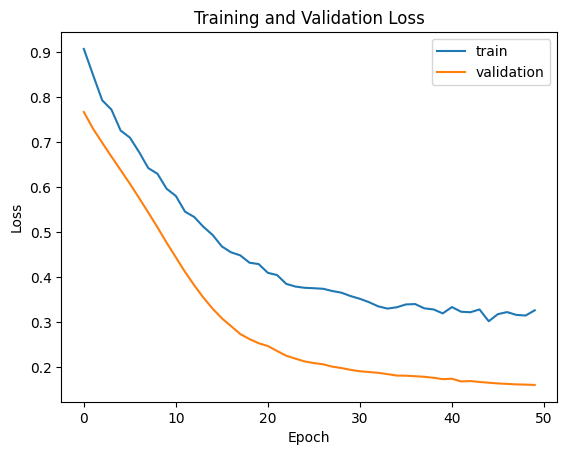

Accuracy for data/jpm_daily.csv: 99.15%
Epoch 1/50
41/41 [==============================] - 1s 5ms/step - loss: 0.8042 - accuracy: 0.5579 - val_loss: 0.7032 - val_accuracy: 0.7086
Epoch 2/50
41/41 [==============================] - 0s 2ms/step - loss: 0.7513 - accuracy: 0.5869 - val_loss: 0.6672 - val_accuracy: 0.7815
Epoch 3/50
41/41 [==============================] - 0s 2ms/step - loss: 0.7172 - accuracy: 0.6159 - val_loss: 0.6357 - val_accuracy: 0.8377
Epoch 4/50
41/41 [==============================] - 0s 2ms/step - loss: 0.6684 - accuracy: 0.6573 - val_loss: 0.6017 - val_accuracy: 0.8675
Epoch 5/50
41/41 [==============================] - 0s 2ms/step - loss: 0.6448 - accuracy: 0.6978 - val_loss: 0.5634 - val_accuracy: 0.9205
Epoch 6/50
41/41 [==============================] - 0s 2ms/step - loss: 0.6226 - accuracy: 0.7078 - val_loss: 0.5235 - val_accuracy: 0.9238
Epoch 7/50
41/41 [==============================] - 0s 2ms/step - loss: 0.6017 - accuracy: 0.7310 - val_loss: 0.4798 - v

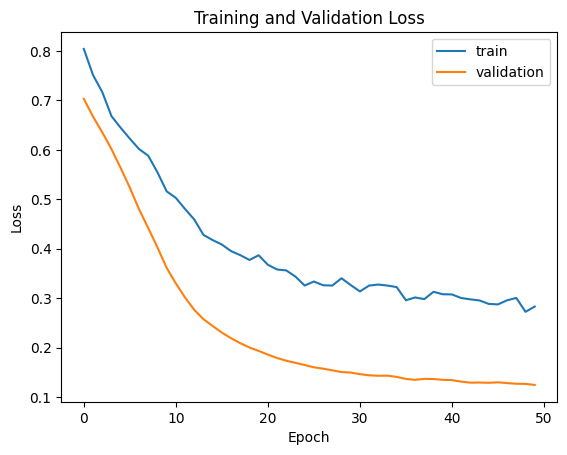

Accuracy for data/xom_daily.csv: 99.01%
Epoch 1/50
30/30 [==============================] - 1s 6ms/step - loss: 0.7813 - accuracy: 0.6047 - val_loss: 0.7506 - val_accuracy: 0.7130
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 0.7539 - accuracy: 0.6194 - val_loss: 0.7360 - val_accuracy: 0.7220
Epoch 3/50
30/30 [==============================] - 0s 2ms/step - loss: 0.7570 - accuracy: 0.6025 - val_loss: 0.7230 - val_accuracy: 0.7354
Epoch 4/50
30/30 [==============================] - 0s 2ms/step - loss: 0.7247 - accuracy: 0.6588 - val_loss: 0.7067 - val_accuracy: 0.7489
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 0.7086 - accuracy: 0.6599 - val_loss: 0.6876 - val_accuracy: 0.7578
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.6655 - val_loss: 0.6700 - val_accuracy: 0.7713
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6784 - accuracy: 0.6791 - val_loss: 0.6482 - v

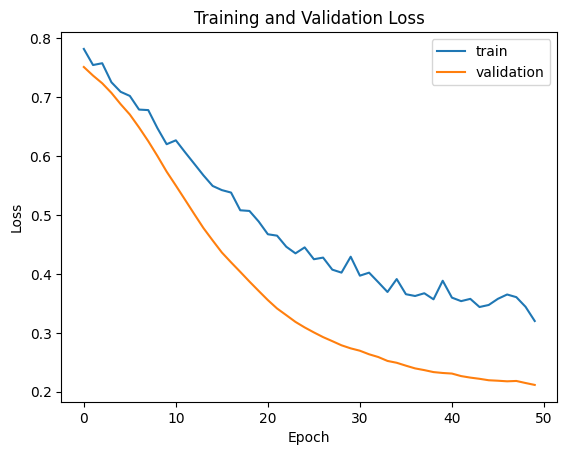

Accuracy for data/jnj_daily.csv: 99.10%


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

def preprocess_data(stock_daily_file, sentiment_file):
    # Load the datasets
    daily_data = pd.read_csv(stock_daily_file)
    sentiment_data = pd.read_csv(sentiment_file)
    
    # Rename the 'time published' column to 'Date' for easy merging
    sentiment_data = sentiment_data.rename(columns={'Time Published': 'Date'})
    sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], format='%Y%m%dT%H%M%S').dt.strftime('%Y-%m-%d')
    
    # Merge the datasets on 'Date'
    merged_data = pd.merge(daily_data, sentiment_data, on='Date')
    
    # Create volatility feature
    merged_data['Volatility'] = merged_data['High'] - merged_data['Low']

    # Create daily price change feature
    merged_data['Daily_Change'] = merged_data['Close'] - merged_data['Open']

    # Create 5-day moving average of close prices
    merged_data['MA_5'] = merged_data['Close'].rolling(window=5).mean()

    # Create Relative Strength Index (RSI)
    window_length = 14
    close = merged_data['Close']
    delta = close.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up1 = up.rolling(window_length).mean()
    roll_down1 = down.abs().rolling(window_length).mean()
    RS = roll_up1 / roll_down1
    merged_data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Shift the sentiment score one day forward
    merged_data['Overall Sentiment Score'] = merged_data['Overall Sentiment Score'].shift(1)

    # After shifting, you will have one row with NaN for the sentiment score, so drop that
    merged_data = merged_data.dropna()

    # Create target variable
    merged_data['Target'] = (merged_data['Close'] - merged_data['Open'] > 0).astype(int)
    merged_data = merged_data.dropna()

    # Split the data into training testing and validation sets
    train_set, test_set = train_test_split(merged_data, test_size=0.2, random_state=42)

    smote = SMOTE(random_state=42)
    X_train = train_set[['Overall Sentiment Score', 'Volatility', 'Daily_Change', 'MA_5', 'RSI']]
    y_train = train_set['Target']
    X_resampled, y_resampled = X_train, y_train

    # Feature scaling
    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    x_test = scaler.transform(test_set[['Overall Sentiment Score', 'Volatility', 'Daily_Change', 'MA_5', 'RSI']])
    y_test = test_set['Target'].values

    return X_resampled, y_resampled, x_test, y_test

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

def build_and_train_model(X_resampled, y_resampled, x_test, y_test):
    # Neural Network with L2 regularization and Dropout
    model = Sequential([
        Dense(10, input_dim=5, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(5, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Train the model with class weights and save the history
    history = model.fit(
        X_resampled, 
        y_resampled, 
        epochs=50, 
        batch_size=30, 
        validation_data=(x_test, y_test),
        verbose=1,
        callbacks=[early_stopping]
    )

    # Get accuracy
    loss, accuracy = model.evaluate(x_test, y_test)
    
    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return accuracy, model

# Files for 4 different stocks (Example: Replace with actual file paths)
stocks_daily_files = ['data/AAPL_daily.csv', 'data/nvda_daily.csv', 'data/jpm_daily.csv', 'data/xom_daily.csv', 'data/jnj_daily.csv']
sentiment_files = ['AAPL_monthly_sentiment2.csv', 'nvda_monthly_sentiment2.csv', 'jpm_monthly_sentiment2.csv', 'xom_monthly_sentiment2.csv', 'jnj_monthly_sentiment2.csv']

# Train models for each stock
models = []
for stock_daily_file, sentiment_file in zip(stocks_daily_files, sentiment_files):
    X_resampled, y_resampled, x_test, y_test = preprocess_data(stock_daily_file, sentiment_file)
    accuracy, model = build_and_train_model(X_resampled, y_resampled, x_test, y_test)
    print(f"Accuracy for {stock_daily_file}: {accuracy * 100:.2f}%")
    models.append(model)


7/7 [==============================] - 0s 1ms/step


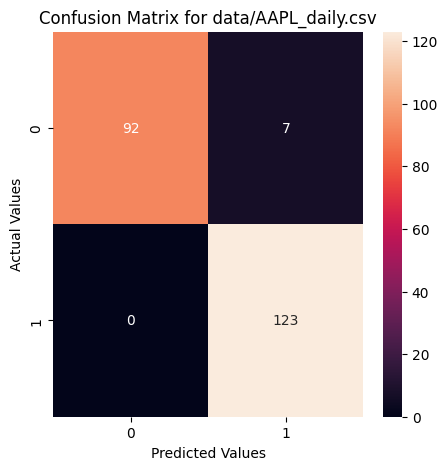

7/7 [==============================] - 0s 774us/step


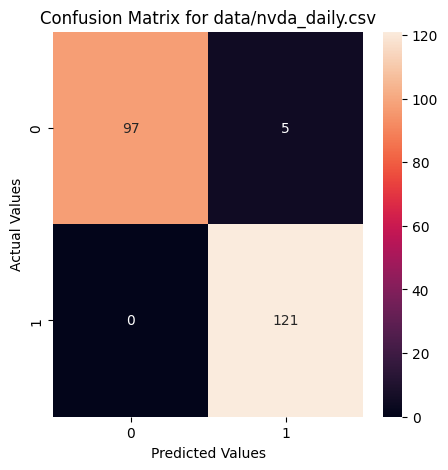

7/7 [==============================] - 0s 1ms/step


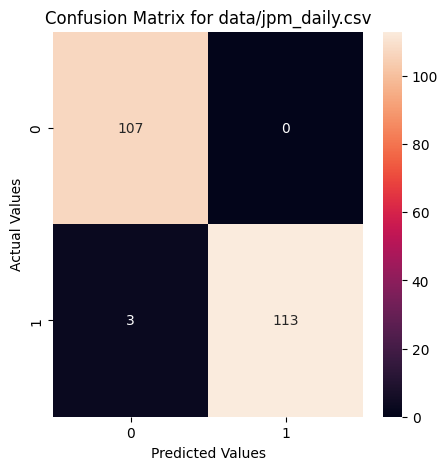

7/7 [==============================] - 0s 975us/step


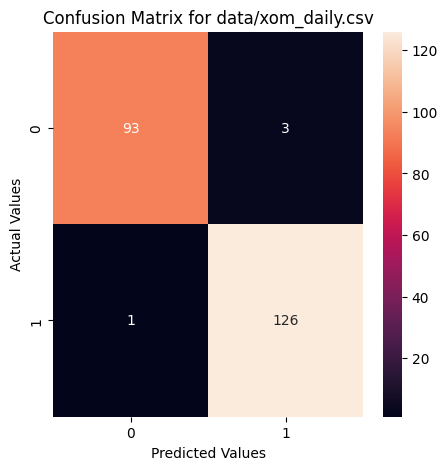

7/7 [==============================] - 0s 1ms/step


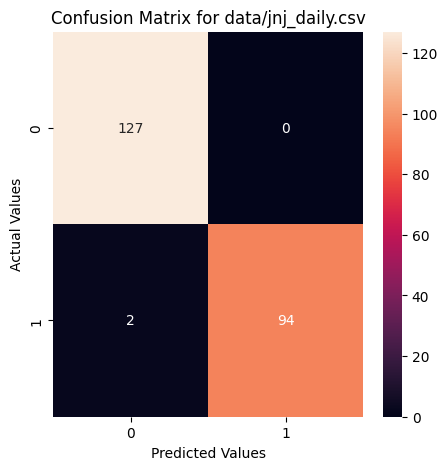

In [2]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# for each stock plot a confusion matrix
for model, stock_daily_file in zip(models, stocks_daily_files):
    X_resampled, y_resampled, x_test, y_test = preprocess_data(stock_daily_file, sentiment_file)
    predictions = model.predict(x_test)
    predictions = (predictions > 0.5).astype(int).reshape(x_test.shape[0])
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix for {stock_daily_file}")
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.show()

In [3]:
# print a table were each row is a stock and the columns are the accuracy, precision, recall, and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# for each stock print the accuracy, precision, recall, and f1 score
for model, stock_daily_file in zip(models, stocks_daily_files):
    X_resampled, y_resampled, x_test, y_test = preprocess_data(stock_daily_file, sentiment_file)
    predictions = model.predict(x_test)
    predictions = (predictions > 0.5).astype(int).reshape(x_test.shape[0])
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print(f"Accuracy for {stock_daily_file}: {accuracy * 100:.2f}%")
    print(f"Precision for {stock_daily_file}: {precision * 100:.2f}%")
    print(f"Recall for {stock_daily_file}: {recall * 100:.2f}%")
    print(f"F1 score for {stock_daily_file}: {f1 * 100:.2f}%")
    print()



7/7 [==============================] - 0s 858us/step
Accuracy for data/AAPL_daily.csv: 96.85%
Precision for data/AAPL_daily.csv: 94.62%
Recall for data/AAPL_daily.csv: 100.00%
F1 score for data/AAPL_daily.csv: 97.23%

7/7 [==============================] - 0s 1ms/step
Accuracy for data/nvda_daily.csv: 97.76%
Precision for data/nvda_daily.csv: 96.03%
Recall for data/nvda_daily.csv: 100.00%
F1 score for data/nvda_daily.csv: 97.98%

7/7 [==============================] - 0s 990us/step
Accuracy for data/jpm_daily.csv: 98.65%
Precision for data/jpm_daily.csv: 100.00%
Recall for data/jpm_daily.csv: 97.41%
F1 score for data/jpm_daily.csv: 98.69%

7/7 [==============================] - 0s 846us/step
Accuracy for data/xom_daily.csv: 98.21%
Precision for data/xom_daily.csv: 97.67%
Recall for data/xom_daily.csv: 99.21%
F1 score for data/xom_daily.csv: 98.44%

7/7 [==============================] - 0s 1ms/step
Accuracy for data/jnj_daily.csv: 99.10%
Precision for data/jnj_daily.csv: 100.00%
Recall

In [4]:
# using validation datasets for sentiment and daily time series make validations for each model

# load data into dataframes
sentiment_validation = [pd.read_csv('validation_sets/AAPL_monthly_sentiment_validation.csv'), 
                        pd.read_csv('validation_sets/NVDA_monthly_sentiment_validation.csv'), 
                        pd.read_csv('validation_sets/JPM_monthly_sentiment_validation.csv'), 
                        pd.read_csv('validation_sets/XOM_monthly_sentiment_validation.csv'), 
                        pd.read_csv('validation_sets/JNJ_monthly_sentiment_validation.csv')]

daily_validation = [pd.read_csv('validation_sets/aapl_daily_validation.csv'),
                    pd.read_csv('validation_sets/nvda_daily_validation.csv'),
                    pd.read_csv('validation_sets/jpm_daily_validation.csv'),
                    pd.read_csv('validation_sets/xom_daily_validation.csv'),
                    pd.read_csv('validation_sets/jnj_daily_validation.csv')]
# preprocess data
def preprocess_validation(sentiment_validation, daily_validation):
    # Rename the 'time published' column to 'Date' for easy merging
    sentiment_validation = sentiment_validation.rename(columns={'Time Published': 'Date'})
    sentiment_validation['Date'] = pd.to_datetime(sentiment_validation['Date'], format='%Y%m%dT%H%M%S').dt.strftime('%Y-%m-%d')
    
    # Merge the datasets on 'Date'
    merged_data = pd.merge(daily_validation, sentiment_validation, on='Date')
    
    # Create volatility feature
    merged_data['Volatility'] = merged_data['High'] - merged_data['Low']

    # Create daily price change feature
    merged_data['Daily_Change'] = merged_data['Close'] - merged_data['Open']

    # Create 5-day moving average of close prices
    merged_data['MA_5'] = merged_data['Close'].rolling(window=5).mean()

    # Create Relative Strength Index (RSI)
    window_length = 14
    close = merged_data['Close']
    delta = close.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up1 = up.rolling(window_length).mean()
    roll_down1 = down.abs().rolling(window_length).mean()
    RS = roll_up1 / roll_down1
    merged_data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Shift the sentiment score one day forward
    merged_data['Overall Sentiment Score'] = merged_data['Overall Sentiment Score'].shift(1)

    # After shifting, you will have one row with NaN for the sentiment score, so drop that
    merged_data = merged_data.dropna()

    # Create target variable
    merged_data['Target'] = (merged_data['Close'] - merged_data['Open'] > 0).astype(int)
    merged_data = merged_data.dropna()

    x_val = merged_data[['Overall Sentiment Score', 'Volatility', 'Daily_Change', 'MA_5', 'RSI']]
    y_val = merged_data['Target']

    return x_val, y_val

# Assuming you have a list of stock names that matches the order of your models
stock_names = ['AAPL', 'NVDA', 'JPM', 'XOM', 'JNJ']

# for each stock, print the accuracy, precision, recall, and f1 score
for stock_name, model, sentiment_df, daily_df in zip(stock_names, models, sentiment_validation, daily_validation):
    x_val, y_val = preprocess_validation(sentiment_df, daily_df)
    predictions = model.predict(x_val)
    predictions = (predictions > 0.5).astype(int).reshape(x_val.shape[0])
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions, zero_division=0)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    print(f"Results for {stock_name}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 score: {f1 * 100:.2f}%")
    print()

    



6/6 [==============================] - 0s 1ms/step
Results for AAPL:
Accuracy: 85.94%
Precision: 85.25%
Recall: 100.00%
F1 score: 92.04%

3/3 [==============================] - 0s 2ms/step
Results for NVDA:
Accuracy: 65.62%
Precision: 100.00%
Recall: 38.89%
F1 score: 56.00%

5/5 [==============================] - 0s 1ms/step
Results for JPM:
Accuracy: 68.18%
Precision: 0.00%
Recall: 0.00%
F1 score: 0.00%

5/5 [==============================] - 0s 1ms/step
Results for XOM:
Accuracy: 46.43%
Precision: 44.44%
Recall: 100.00%
F1 score: 61.54%

3/3 [==============================] - 0s 2ms/step
Results for JNJ:
Accuracy: 71.76%
Precision: 67.12%
Recall: 100.00%
F1 score: 80.33%



In [5]:
# predict from user input for each stock
def predict_from_input(model, scaler):
    # Get user input
    print("Enter the following values for the stock you want to predict:")
    sentiment_score = float(input("Overall Sentiment Score: "))
    volatility = float(input("Volatility: "))
    daily_change = float(input("Daily Change: "))
    ma_5 = float(input("5-day Moving Average: "))
    rsi = float(input("Relative Strength Index: "))

    # Scale the input
    input_data = [[sentiment_score, volatility, daily_change, ma_5, rsi]]
    input_data = scaler.transform(input_data)

    # Predict
    prediction = model.predict(input_data)
    prediction = (prediction > 0.5).astype(int).reshape(input_data.shape[0])
    if prediction[0] == 1:
        print("The stock price will go up tomorrow.")
    else:
        print("The stock price will go down tomorrow.")

# for each stock predict from user input
for model, stock_daily_file in zip(models, stocks_daily_files):
    X_resampled, y_resampled, x_test, y_test = preprocess_data(stock_daily_file, sentiment_file)
    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    print(f"Predicting for {stock_daily_file}")
    predict_from_input(model, scaler)
    print()

Predicting for data/AAPL_daily.csv
Enter the following values for the stock you want to predict:
1/1 [==============================] - 0s 18ms/step
The stock price will go up tomorrow.

Predicting for data/nvda_daily.csv
Enter the following values for the stock you want to predict:


ValueError: could not convert string to float: ''